In [158]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('dark_background')
import re
import string
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from nltk.stem.porter import PorterStemmer
from textblob import TextBlob

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

In [2]:
aita = pd.read_csv('data/aita_clean.csv')
aita.drop('id', axis=1, inplace=True)

In [3]:
print(f'There are {aita.shape[0]} posts before dropping NA')
aita.dropna(inplace=True)
print(f'There are {aita.shape[0]} posts after dropping NA')

There are 97628 Posts before dropping NA
There are 97541 Posts after dropping NA


not the asshole     59069
asshole             20921
no assholes here    12001
everyone sucks       5550
Name: verdict, dtype: int64

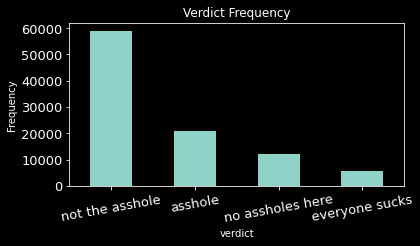

In [138]:
aita.value_counts('verdict').plot(kind='bar', figsize=(6, 3), ylabel='Frequency',title='Verdict Frequency', fontsize=13, rot=10);
aita.verdict.value_counts()

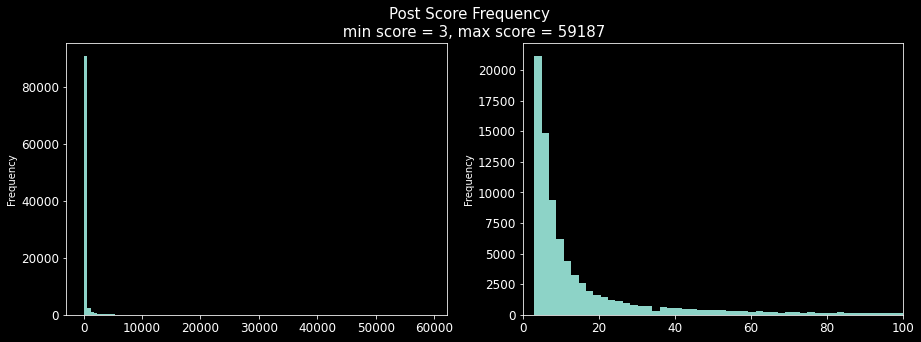

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
aita.score.plot(kind='hist', bins=100, ax=ax[0], fontsize=12);
aita.score[aita.score <= 100].plot(kind='hist', bins=50, ax=ax[1], xlabel='Post Score', xlim=(0,100),fontsize=12)
plt.ylabel('Frequency')
plt.suptitle(f'Post Score Frequency \n min score = {aita.score.min()}, max score = {aita.score.max()}', fontsize=15);

In [7]:
def clean_body(text):
    # remove new line, *, links
    text = text.replace('\n',' ').replace('*','')
    text = re.sub('(https?\S+|www.\S+)','', text)
    return text.lower()
    
def poster_age_sex(text):
    find = re.findall('(?:i|i am a|my|i.?m a?)\s?\(?\[?([0-9]{2}) ?([mf][t]?[mf]?)\)?\]?', text)
    if find:
        return int(find[0][0]), find[0][1]
    else: 
        return 0,'NA'

In [8]:
aita['body_clean'] = aita['body'].apply(lambda x : clean_body(x))
aita['age'] = aita['body_clean'].apply(lambda x : poster_age_sex(x)[0])
aita['sex'] = aita['body_clean'].apply(lambda x : poster_age_sex(x)[1])
aita['sex'] = aita['sex'].replace(['mf'],'m')
aita['sex'] = aita['sex'].replace(['fm'],'m')

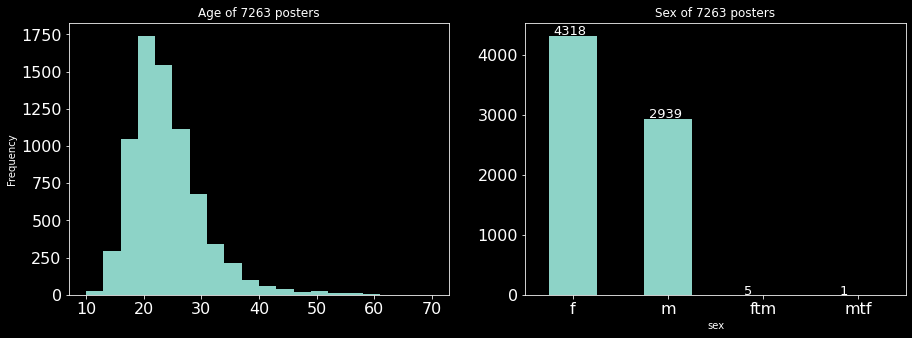

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
age = aita['age'][aita.age != 0]
sex = aita['sex'][aita.sex != 'NA']
ax[0] = age.plot(kind='hist', bins=20, ax=ax[0], title=f'Age of {len(age)} posters', xlabel='Age', fontsize=16)
ax[1] = sex.value_counts().plot(kind='bar', ax=ax[1], title=f'Sex of {len(sex)} posters', xlabel='sex', fontsize=16, rot=0)

for p in ax[1].patches:
    ax[1].annotate(str(p.get_height()), (p.get_x()+.05, p.get_height() * 1.005),fontsize=13)

## Adding sentiment columns to aita table

In [111]:
aita['polarity'] = aita['body_clean'].apply(lambda x : TextBlob(x).sentiment.polarity)
aita['subjectivity'] = aita['body_clean'].apply(lambda x : TextBlob(x).sentiment.subjectivity)

In [135]:
aita[['polarity','subjectivity','is_asshole']].groupby('is_asshole').agg({'polarity': ['min','mean','max'],'subjectivity':['min','mean','max']})

polarity                   subjectivity               
                min      mean     max          min      mean  max
is_asshole                                                       
0            -0.825  0.044159  0.8625          0.0  0.476231  1.0
1            -1.000  0.044660  0.7000          0.0  0.479340  1.0

## cleaning posts

In [136]:
def remove_punc(s):
    s = s.lower()
    s = re.sub('\[.*?\]', '', s)
    s = re.sub('[%s]' % re.escape(string.punctuation), '', s)
    s = re.sub('[‘’“”…]', '', s)
    s = re.sub('\w*\d\w*', '', s)

    stop = set(stopwords.words('english'))
    stop.add('aita')
    stop.add('wibta')

    stemmer = PorterStemmer()
    s = ' '.join([stemmer.stem(word) for word in s.split() if word not in stop])
    return s

In [137]:
body_corpus = aita.body_clean.apply(lambda x : remove_punc(x))
title_corpus = aita.title.apply(lambda x : remove_punc(x))

In [139]:
title_corpus

0                         wrote explan til came condescend
1                                  threw parent donut away
2                           told goth girl look like clown
3                           argument anoth redditor rhimym
5                                   disagr le miser cowork
                               ...                        
97623                               tell sister spoil brat
97624    tell husband f relentlessli request sing also ...
97625                    attempt keep student adult matter
97626                              left brother fate state
97627                rock boat work mentor homophob toward
Name: title, Length: 97541, dtype: object

In [90]:
lemmatizer = WordNetLemmatizer()
lemmatizer.lemmatize('homophobic')

'homophobic'

In [155]:
stemmer = PorterStemmer()
stemmer.stem('homophobe')

'homophob'

In [140]:
vec = CountVectorizer()
body_cv = vec.fit_transform(body_corpus)
# Counter(Vec_n_gram).most_common()

In [142]:
body_dtm = pd.DataFrame(body_cv.toarray(), columns=vec.get_feature_names())
body_dtm

,aa,aaa,aaaaaa,aaaaaaaa,aaaaaaaaaaaaaaaaaand,aaaaaaaaaaaaaaaanyway,aaaaaaaaaaarrrrrrrggggggghhhhh,aaaaaaag,aaaaaaand,aaaaaand,...,𝗺𝗲𝗻,𝗼𝗳,𝗼𝘂𝗿,𝗿𝗮𝗻𝗱𝗼𝗺,𝘀𝗼𝗺𝗲,𝘁𝗶𝗻𝗱𝗲𝗿,𝘂𝘀,𝘄𝗿𝗶𝘁𝗲,𝘢𝘯𝘺𝘰𝘯𝘦,𝚂he
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97536,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97537,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97538,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
97539,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [144]:
corpus_word_count = body_dtm.sum(axis=0)

In [153]:
corpus_word_count.sort_values(ascending=False)[:100]

im         165463
get        145692
want       145356
like       142657
go         132734
            ...  
right       28099
put         28085
away        27760
brother     27651
thought     27579
Length: 100, dtype: int64

In [159]:
X = body_dtm
y = aita['is_asshole']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
X_train

In [ ]:
rfc = RandomForestClassifier()
rfc.fit(X_train, y_train)